In [1]:
%load_ext autoreload
%autoreload 2
import sys
import os
import pandas as pd
from datetime import datetime
import lightgbm as lgb
from dotenv import load_dotenv
load_dotenv() 
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from src.config import TRANSFORMED_DATA_DIR
from src.data_utils import split_time_series_data
from src.experiment_utils import set_mlflow_tracking, log_model_to_mlflow

In [2]:
# Function to check stationarity
def check_stationarity(time_series):
    result = adfuller(time_series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is NOT stationary. Consider differencing.")

# Function to fit ARMA model
def fit_arma_model(train_data, ar_order, ma_order):
    model = ARIMA(train_data, order=(ar_order, 0, ma_order))  # ARMA is a special case of ARIMA with d=0
    results = model.fit()
    print(results.summary())
    return results

# Function to evaluate predictions
def evaluate_predictions(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    return mae



In [3]:
def split_time_series_data_percentage(
    df: pd.DataFrame,
    target_column: str,
) -> tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Splits a time series DataFrame into training, validation, and testing sets (70%, 20%, 10%).

    Args:
        df (pd.DataFrame): The input DataFrame containing the time series data.
        target_column (str): The name of the target column to separate from the features.

    Returns:
        Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
            - X_train (pd.DataFrame): Training features (70% of data).
            - y_train (pd.Series): Training target values.
            - X_val (pd.DataFrame): Validation features (20% of data).
            - y_val (pd.Series): Validation target values.
            - X_test (pd.DataFrame): Testing features (10% of data).
            - y_test (pd.Series): Testing target values.
    """
    # Sort the DataFrame by date
    df_sorted = df.sort_values("pickup_hour")

    # Calculate the split indices
    train_end = int(len(df) * 0.5)
    val_end = int(len(df) * 0.8)

    # Split the data into training, validation, and testing sets
    train_data = df_sorted[:train_end].reset_index(drop=True)
    val_data = df_sorted[train_end:val_end].reset_index(drop=True)
    test_data = df_sorted[val_end:].reset_index(drop=True)

    # Separate features (X) and target (y) for all three sets
    X_train = train_data.drop(columns=[target_column])
    y_train = train_data[target_column]
    X_val = val_data.drop(columns=[target_column])
    y_val = val_data[target_column]
    X_test = test_data.drop(columns=[target_column])
    y_test = test_data[target_column]

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
df = pd.read_parquet(TRANSFORMED_DATA_DIR / "tabular_data.parquet")
df.head(5)
df.shape
X_train, y_train, X_val, y_val, X_test, y_test = split_time_series_data_percentage(df, target_column="target")

                               SARIMAX Results                                
Dep. Variable:                 target   No. Observations:                43810
Model:                 ARIMA(2, 0, 2)   Log Likelihood             -222340.028
Date:                Wed, 05 Mar 2025   AIC                         444692.056
Time:                        13:34:38   BIC                         444744.182
Sample:                             0   HQIC                        444708.485
                              - 43810                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.4407      1.332      8.587      0.000       8.829      14.052
ar.L1          0.1135      0.065      1.737      0.082      -0.015       0.241
ar.L2          0.8806      0.065     13.526      0.0

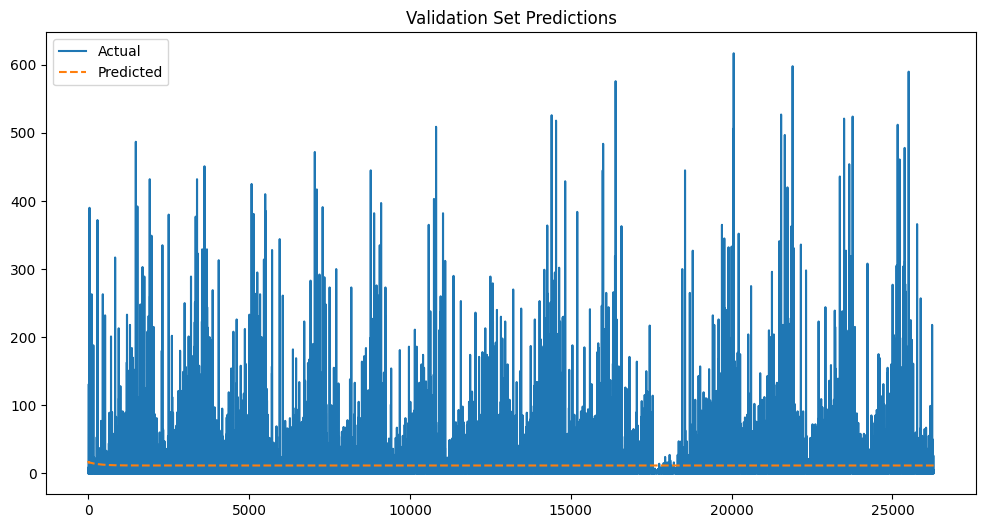

Mean Absolute Error (MAE): 17.53


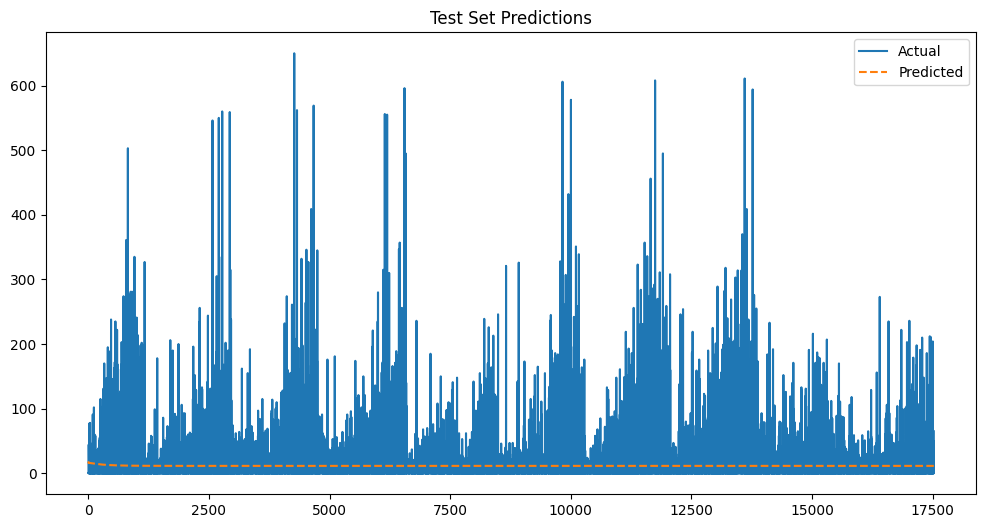

Mean Absolute Error (MAE): 18.84
Test Set MAE: 18.84


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt

# Function to fit ARIMA model
def fit_arima_model(train_data, p, d, q):
    try:
        # Fit ARIMA model
        model = ARIMA(train_data, order=(p, d, q))
        results = model.fit()
        print(results.summary())
        return results
    except Exception as e:
        print(f"Error fitting ARIMA({p},{d},{q}): {e}")
        return None

# Function to evaluate predictions
def evaluate_predictions(test_data, predictions):
    mae = mean_absolute_error(test_data, predictions)  # Removed `.values`
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    return mae

# Step 1: Fit ARIMA Model (choose initial parameters based on ACF/PACF plots or experimentation)
p = 2  # AutoRegressive order
d = 0  # Differencing order (already stationary)
q = 2  # Moving Average order
arima_results = fit_arima_model(y_train, p, d, q)

# Step 2: Forecast on validation set
forecast_val = arima_results.forecast(steps=len(y_val))
plt.figure(figsize=(12, 6))
plt.plot(y_val.index, y_val.values, label="Actual")
plt.plot(y_val.index, forecast_val.values, label="Predicted", linestyle="--")
plt.title("Validation Set Predictions")
plt.legend()
plt.show()

# Step 3: Evaluate predictions on validation set
evaluate_predictions(y_val.values, forecast_val)  # Removed `.values` from `forecast_val`

# Step 4: Forecast on test set and plot results
forecast_test = arima_results.forecast(steps=len(y_test))
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, forecast_test.values, label="Predicted", linestyle="--")
plt.title("Test Set Predictions")
plt.legend()
plt.show()

# Evaluate test set predictions
test_mae = evaluate_predictions(y_test.values, forecast_test)  # Removed `.values` from `forecast_test`
print(f"Test Set MAE: {test_mae:.2f}")
